# MiniProject 3 -  Classification of Image Data with Multilayer Perceptrons and Convolutional Neural Networks

Gabriel Caballero (261108565)
Adam Dufour (261193949)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset
import torch.nn.functional as F
import time

In [9]:
np.random.seed(551)
torch.manual_seed(551)

In [10]:
def to_numpy(x):
  """
  converts a pytorch tensor to a numpy array
  """
  return x.detach().cpu().numpy()

# Task 1: Acquire the data

In [11]:
# acquiring data
raw_train = datasets.FashionMNIST(root='./data', train=True, download=True)
raw_test = datasets.FashionMNIST(root='./data', train=False, download=True)

X_raw = raw_train.data.float()
y_raw = raw_train.targets

X_test = raw_test.data.float()
y_test = raw_test.targets

100.0%
100.0%
100.0%
100.0%


In [12]:
# splitting into train and validation (80/20)
num_train = X_raw.shape[0]
indices = torch.randperm(num_train)

split_idx = int(0.8 * num_train)
train_idx, val_idx = indices[:split_idx], indices[split_idx:]

X_train, y_train = X_raw[train_idx], y_raw[train_idx]
X_val, y_val = X_raw[val_idx], y_raw[val_idx]

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: torch.Size([48000, 28, 28])
Validation set shape: torch.Size([12000, 28, 28])
Test set shape: torch.Size([10000, 28, 28])


In [13]:
def show_grid(data, labels, title, n=10):
  fig, axs = plt.subplots(2, 5, figsize=(8, 4))
  fig.suptitle(title)

  for i in range(n):
    ax = axs[i // 5][i % 5]
    ax.imshow(data[i], cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

  plt.tight_layout()
  plt.show()

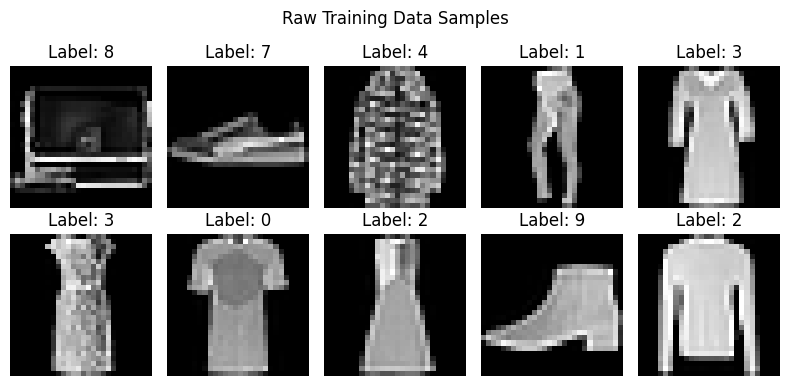

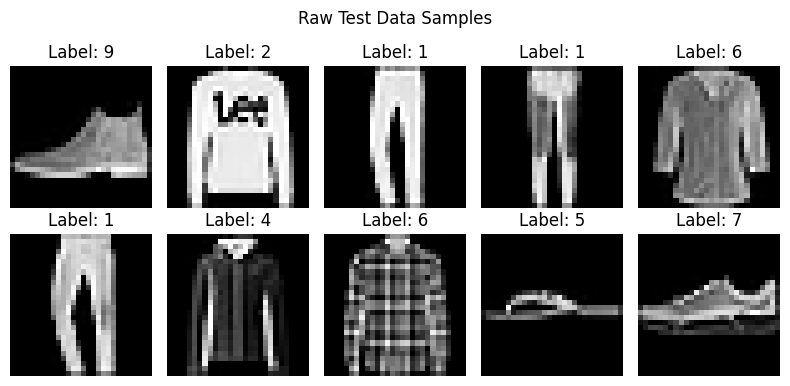

In [14]:
show_grid(X_train, y_train, "Raw Training Data Samples")
show_grid(X_test, y_test, "Raw Test Data Samples")

## Preprocessing
Inspiration taken from: https://cs231n.github.io/neural-networks-2/#datapre

In [15]:
# Flattening: Reshape (N, 28, 28) -> (N, 784)
X_train_flat = X_train.view(X_train.shape[0], -1)
X_val_flat = X_val.view(X_val.shape[0], -1)
X_test_flat = X_test.view(X_test.shape[0], -1)

print(f"Training set shape: {X_train_flat.shape}")
print(f"Validation set shape: {X_val_flat.shape}")
print(f"Test set shape: {X_test_flat.shape}")

Training set shape: torch.Size([48000, 784])
Validation set shape: torch.Size([12000, 784])
Test set shape: torch.Size([10000, 784])


In [16]:
# Scaling to [0, 1]
X_train_scaled = X_train_flat / 255.0
X_val_scaled = X_val_flat / 255.0
X_test_scaled = X_test_flat / 255.0

In [17]:
# Zero Centering
# calculating mean only on training data
mean_vector = torch.mean(X_train_scaled, dim=0)

X_train_zc = X_train_scaled - mean_vector
X_val_zc = X_val_scaled - mean_vector
X_test_zc = X_test_scaled - mean_vector

In [18]:
# PCA / Whitening
# calculating covariance matrix on training data (D, N) @ (N, D) -> (D, D)
N = X_train_zc.shape[0]
cov = (X_train_zc.T @ X_train_zc) / N

# eigen decomposition
eigvals, U = torch.linalg.eigh(cov)

# eigh returns the eigenvalues/vectors in asc, so we need to reverse
eigvals_full = eigvals.flip(0)
U_full = U.flip(1)

In [19]:
cumvar = torch.cumsum(eigvals_full, dim=0) / torch.sum(eigvals_full)

K_90 = int((cumvar < 0.90).sum().item() + 1)
K_95 = int((cumvar < 0.95).sum().item() + 1)
K_99 = int((cumvar < 0.99).sum().item() + 1)

print("Components needed for 90% variance:", K_90)
print("Components needed for 95% variance:", K_95)
print("Components needed for 99% variance:", K_99)

Components needed for 90% variance: 84
Components needed for 95% variance: 187
Components needed for 99% variance: 458


In [20]:
def visualize_pca_spectrum(eigvals_full, K_90, K_95, K_99, max_log_components=200):
  ev = to_numpy(eigvals_full)
  cumvar = to_numpy(torch.cumsum(eigvals_full, dim=0) / torch.sum(eigvals_full))

  plt.figure(figsize=(18, 4))

  # normal scree plot (full)
  plt.subplot(1, 3, 1)
  plt.plot(ev)
  plt.title("Scree Plot (Eigenvalues)")
  plt.xlabel("Component index")
  plt.ylabel("Eigenvalue")
  plt.grid(True)

  # log-scale scree plot (first n)
  plt.subplot(1, 3, 2)
  m = min(max_log_components, len(ev))
  plt.plot(ev[:m])
  plt.yscale('log')
  plt.title(f"Log-Scree Plot (first {m} components)")
  plt.xlabel("Component index")
  plt.ylabel("Eigenvalue (log scale)")
  plt.grid(True)

  # cumulative variance
  plt.subplot(1, 3, 3)
  plt.plot(cumvar)
  plt.title("Cumulative Variance Accounted For")
  plt.xlabel("Number of components")
  plt.ylabel("Cumulative variance")
  plt.grid(True)

  # adding where the K90, K95, and K99 lay
  plt.axvline(K_90, color='red', linestyle='--', label=f"90% ({K_90})")
  plt.axvline(K_95, color='green', linestyle='--', label=f"95% ({K_95})")
  plt.axvline(K_99, color='purple', linestyle='--', label=f"99% ({K_99})")
  plt.legend(loc="lower right")

  plt.tight_layout()
  plt.show()


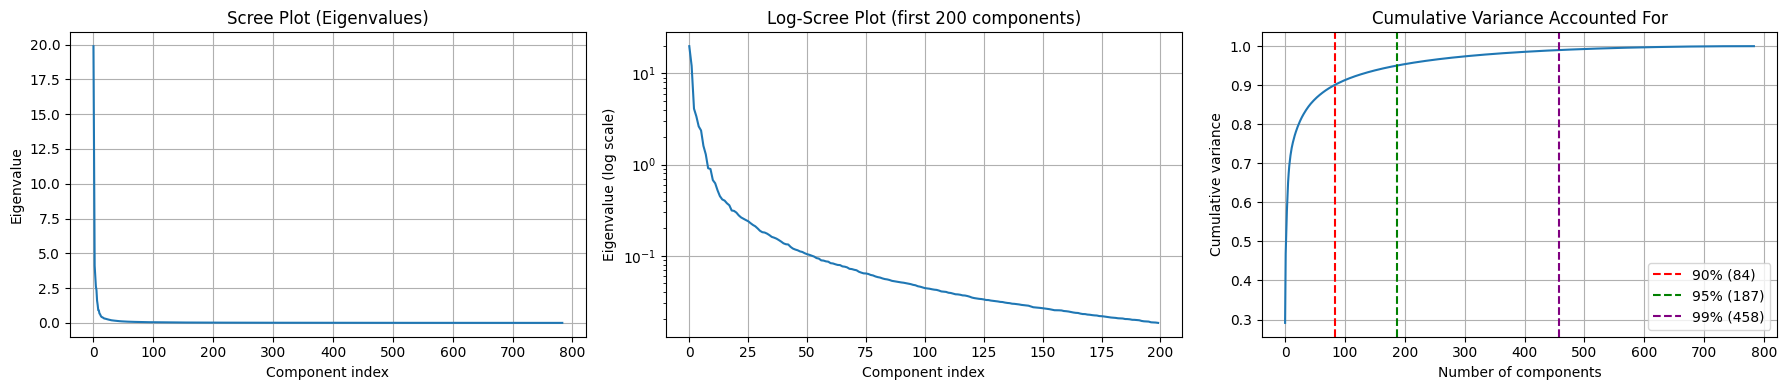

In [21]:
visualize_pca_spectrum(eigvals_full, K_90, K_95, K_99)

In [22]:
# reduce (keep top 200 components)
K = 200
U = U_full[:, :K]
eigvals = eigvals_full[:K]

# decorrelate (rotate)
X_train_rot = X_train_zc @ U
X_val_rot = X_val_zc @ U
X_test_rot = X_test_zc @ U

# whiten by dividing by sqrt of eigenvalues + epsilon
epsilon = 1e-5
X_train_white = X_train_rot / torch.sqrt(eigvals + epsilon)
X_val_white = X_val_rot / torch.sqrt(eigvals + epsilon)
X_test_white = X_test_rot / torch.sqrt(eigvals + epsilon)

In [23]:
def visualize_covariance():
    cov_pca = (X_train_rot.T @ X_train_rot) / N
    cov_white = (X_train_white.T @ X_train_white) / N

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    im0 = axs[0].imshow(to_numpy(cov), cmap='coolwarm')
    axs[0].set_title("Full Covariance\n(784×784)")

    im2 = axs[1].imshow(to_numpy(cov_pca), cmap='coolwarm')
    axs[1].set_title("Covariance in\nPCA Space")

    im3 = axs[2].imshow(to_numpy(cov_white), cmap='coolwarm')
    axs[2].set_title("Covariance After\nWhitening")

    plt.show()

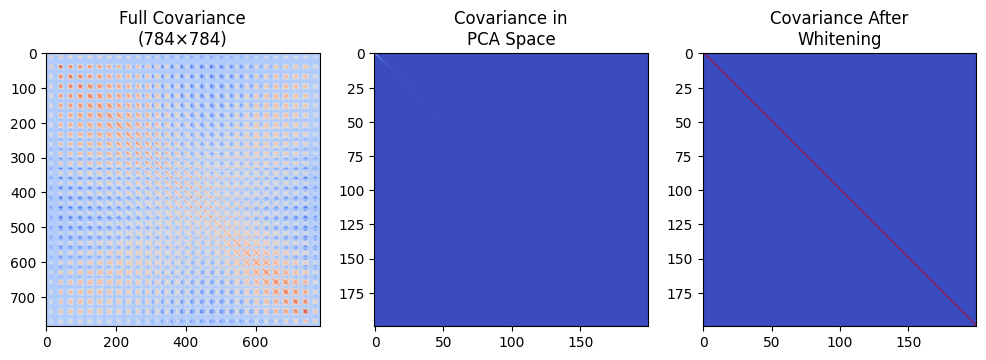

In [24]:
visualize_covariance()

In [25]:
def visualize_preprocesing(idx):
  plt.figure(figsize=(12, 4))

  # original
  orig = to_numpy(X_train_flat[idx]).reshape(28, 28)

  plt.subplot(1, 3, 1)
  plt.imshow(orig, cmap='gray')
  plt.title('Original')
  plt.axis('off')

  # zero centered
  zc = to_numpy(X_train_zc[idx]).reshape(28, 28)

  plt.subplot(1, 3, 2)
  plt.imshow(zc, cmap='gray')
  plt.title('Zero-centered')
  plt.axis('off')

  # reconstructed from reduced data (100 features)
  white_sample = X_train_white[idx]
  unwhite = white_sample * torch.sqrt(eigvals + epsilon)
  reconstructed_vector = unwhite @ U.T
  reconstructed_vector += mean_vector
  reconstructed_img = to_numpy(reconstructed_vector).reshape(28, 28)

  plt.subplot(1, 3, 3)
  plt.imshow(reconstructed_img, cmap='gray')
  plt.title(f'Reconstructed (from {K} features)')
  plt.axis('off')

  plt.tight_layout()
  plt.show()

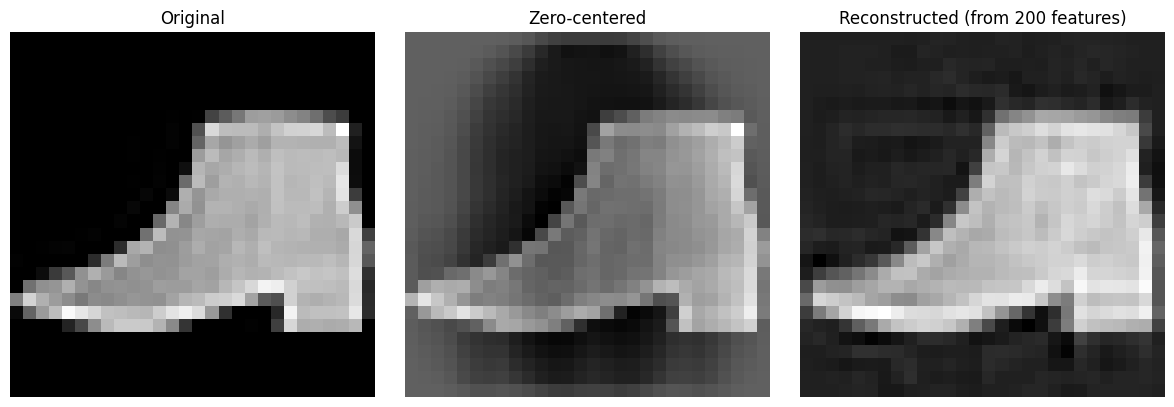

In [26]:
visualize_preprocesing(8)

In [27]:
def plot_pca_reconstructions(idx, Ks=[200, 100, 50, 10]):
  plt.figure(figsize=(3 * (len(Ks) + 1), 3))

  # original
  orig = to_numpy(X_train_flat[idx]).reshape(28, 28)
  plt.subplot(1, len(Ks) + 1, 1)
  plt.imshow(orig, cmap='gray')
  plt.title('Original')
  plt.axis('off')

  # reconstructions with different Ks
  for i, K in enumerate(Ks):
    principal_components = U_full[:, :K] # selecting the first K principal components
    pca_coordinates = X_train_zc[idx] @ principal_components
    x_zc_reconstructed = pca_coordinates @ principal_components.T
    x_reconstructed = x_zc_reconstructed + mean_vector

    reconstructed_img = to_numpy(x_reconstructed).reshape(28, 28)

    plt.subplot(1, len(Ks) + 1, i + 2)
    plt.imshow(reconstructed_img, cmap='gray')
    plt.title(f'{K} features')
    plt.axis('off')

  plt.tight_layout()
  plt.show()

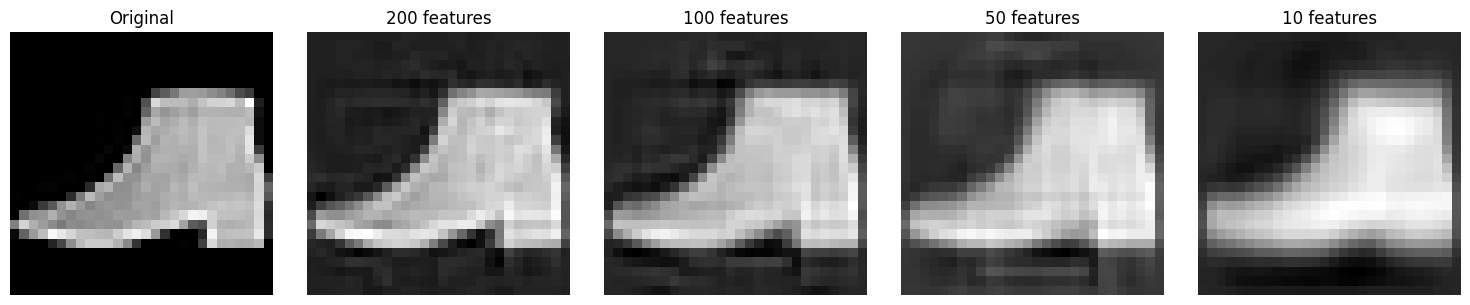

In [28]:
plot_pca_reconstructions(8)

In [29]:
def plot_pca_components(n_components=9):
  side = int(np.ceil(np.sqrt(n_components)))
  plt.figure(figsize=(2.5 * side, 2.5 * side))

  for i in range(n_components):
    img = to_numpy(U_full[:, i]).reshape(28, 28)
    plt.subplot(side, side, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'PC {i + 1}')
    plt.axis('off')

  plt.tight_layout()
  plt.show()

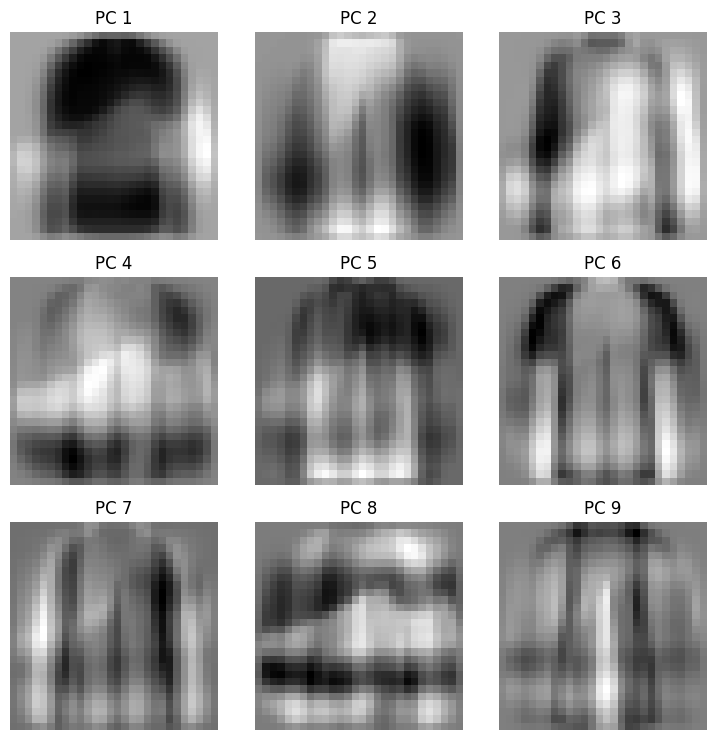

In [30]:
plot_pca_components()

In [31]:
# Convert to NumPy
X_train_np = to_numpy(X_train_white).astype(np.float32)
y_train_np = to_numpy(y_train).astype(np.int64)

X_val_np = to_numpy(X_val_white).astype(np.float32)
y_val_np = to_numpy(y_val).astype(np.int64)

X_test_np = to_numpy(X_test_white).astype(np.float32)
y_test_np = to_numpy(y_test).astype(np.int64)

In [32]:
# Convert Unnormalized Data to Numpy
X_train_unnormalized = to_numpy(X_train_flat).astype(np.float32)
X_val_unnormalized = to_numpy(X_val_flat).astype(np.float32)
X_test_unnormalized = to_numpy(X_test_flat).astype(np.float32)

In [33]:
# just /255, no zc, no PCA/whitening
X_train_simple = to_numpy(X_train_scaled).astype(np.float32)
X_val_simple = to_numpy(X_val_scaled).astype(np.float32)
X_test_simple  = to_numpy(X_test_scaled).astype(np.float32)

# Task 2 - Implementation of a MLP

In [34]:
class MLP:
  def __init__(self, input_dim, hidden_layers, output_dim, activation="relu", l1_lambda=0.0, l2_lambda=0.0):
    """
    input_dim (int): dimension of input features
    hidden_layers (list): list of integers defining hidden layer sizes
    output_dim (int): number of classes
    activation (str): "relu", "sigmoid", "tanh", or "leaky_relu" (optional)
    l1_lambda (float): L1 regularization strength (optional)
    l2_lambda (float): L2 regularization strength (optional)
    """
    self.input_dim = input_dim
    self.hidden_layers = hidden_layers
    self.output_dim = output_dim
    self.activation = activation
    self.l1_lambda = l1_lambda
    self.l2_lambda = l2_lambda

    self.weights = []
    self.biases = []

    # structure [input -> hidden1 -> ... -> hiddenN -> output]
    self.layers = [input_dim] + hidden_layers + [output_dim]

    for i in range(len(self.layers) - 1):
      in_dim = self.layers[i]
      out_dim = self.layers[i + 1]

      W = np.random.randn(in_dim, out_dim) * 0.01
      b = np.zeros((1, out_dim))

      self.weights.append(W)
      self.biases.append(b)

    self.num_layers = len(self.weights)

  def _activation(self, z):
    if self.activation == "sigmoid":
      return 1 / (1 + np.exp(-z))
    if self.activation == "tanh":
      return np.tanh(z)
    if self.activation == "leaky_relu":
      return np.where(z > 0, z, 0.01 * z)
    return np.maximum(0, z) # relu

  def _activation_derivative(self, a):
    """
    derivative of activation function with respect to Z
    'a' is the activation output (a = f(z)), not z
    """
    if self.activation == "sigmoid":
      return a * (1 - a)
    if self.activation == "tanh":
      return 1 - a**2
    if self.activation == "leaky_relu":
      # if a > 0 -> derivative = 1
      # else a <= 0 -> derivative = alpha
      alpha = 0.01
      return np.where(a > 0, 1.0, alpha)

    # relu'(z) = 1 if z > 0, else 0
    # since a = max(0, z), we check a > 0
    return (a > 0).astype(float)

  def _softmax(self, z):
    z_max = np.max(z, axis=1, keepdims=True) # max per row (sample)
    exp_z = np.exp(z - z_max) # subtract max (prevent overflow with large exp)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True) # divide by sum of exp for each row

  def forward(self, X):
    """
    returns a list of activaations for each layer
    """
    activations = [X] # A0

    current = X

    # hidden layers
    for i in range(self.num_layers - 1):
      W = self.weights[i]
      b = self.biases[i]

      z = np.dot(current, W) + b
      a = self._activation(z)

      activations.append(a)
      current = a

    # output layer (logits -> softmax)
    W = self.weights[-1]
    b = self.biases[-1]

    z = np.dot(current, W) + b
    a = self._softmax(z)

    activations.append(a)

    return activations

  def backward(self, activations, y):
    N = y.shape[0]
    grads_w = []
    grads_b = []

    # 1) output layer gradient (softmax + cross entropy)
    A_curr = activations[-1]
    delta = A_curr - y

    # gradients for last layer weights/biases
    A_prev = activations[-2]

    dW = np.dot(A_prev.T, delta) / N
    db = np.sum(delta, axis=0, keepdims=True) / N

    W_last = self.weights[-1]

    if self.l1_lambda > 0:
      dW += self.l1_lambda * np.sign(W_last)
    if self.l2_lambda > 0:
      dW += self.l2_lambda * W_last

    grads_w.append(dW)
    grads_b.append(db)

    # 2) hidden layers
    for i in range(self.num_layers - 2, -1, -1):
      W_next = self.weights[i + 1]
      A_curr = activations[i + 1]
      A_prev = activations[i]

      delta = np.dot(delta, W_next.T) * self._activation_derivative(A_curr)

      dW = np.dot(A_prev.T, delta) / N
      db = np.sum(delta, axis=0, keepdims=True) / N

      W_curr = self.weights[i]

      if self.l1_lambda > 0:
        dW += self.l1_lambda * np.sign(W_curr)
      if self.l2_lambda > 0:
        dW += self.l2_lambda * W_curr

      grads_w.append(dW)
      grads_b.append(db)

    grads_w.reverse()
    grads_b.reverse()

    return grads_w, grads_b

  # cross entropy loss
  def compute_loss(self, y_true, y_pred):
    """
    y_true: one-hot vector of true labels
    y_pred: predicted probabilities
    """
    N = y_true.shape[0]
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15) # clip y_pred to avoid log(0)
    loss = -np.sum(y_true * np.log(y_pred)) / N

    l1_loss = 0.0
    l2_loss = 0.0

    if self.l1_lambda > 0 or self.l2_lambda > 0:
      for W in self.weights:
        l1_loss += np.sum(np.abs(W))
        l2_loss += np.sum(W * W)

    loss += (self.l1_lambda * l1_loss) + (self.l2_lambda * l2_loss / 2)

    return loss

  def fit(self, X, y, epochs=50, lr=0.01, batch_size=64, verbose=False):
    N = X.shape[0]
    num_classes = self.output_dim

    # one-hot encode targets
    y_onehot = np.zeros((N, num_classes))
    y_onehot[np.arange(N), y] = 1

    loss_history = []

    for epoch in range(epochs):
      # shuffle data
      indices = np.random.permutation(N)
      X_shuffled = X[indices]
      y_shuffled = y_onehot[indices]

      # mini-batch gradient descent
      for start in range(0, N, batch_size):
        end = start + batch_size
        X_batch = X_shuffled[start:end]
        y_batch = y_shuffled[start:end]

        # forward
        activations = self.forward(X_batch)

        # backward
        grads_w, grads_b = self.backward(activations, y_batch)

        # update weights/biases
        for i in range(self.num_layers):
          self.weights[i] -= lr * grads_w[i]
          self.biases[i] -= lr * grads_b[i]

      if verbose:
        # print only every 10 epochs (and the last one)
        if epoch % 10 == 0 or epoch == epochs - 1:
          full_activations = self.forward(X)
          y_pred = full_activations[-1]
          loss = self.compute_loss(y_onehot, y_pred)
          loss_history.append(loss)
          print(f"Epoch {epoch}, Loss: {loss:.4f}")

    return loss_history

  def predict(self, X):
    activations = self.forward(X)
    y_prob = activations[-1]
    return np.argmax(y_prob, axis=1)

In [35]:
def evaluate_acc(y_true, y_pred):
  accuracy = np.mean(y_true == y_pred)
  return accuracy

# Task 3 - Running the experiments

## Baseline Hyperparameters
We'll be using a baseline MLP:
- 2 hidden layers
- 256 units each
- ReLu

to find the good hyperparameters that we will then reuse the comparisons

In [36]:
lr_candidates = [0.001, 0.01, 0.05]
lr_tuning_results = {}

for lr in lr_candidates:
    mlp = MLP(
        input_dim=X_train_np.shape[1],
        hidden_layers=[256, 256],
        output_dim=10,
        activation="relu",
    )

    mlp.fit(
        X_train_np, y_train_np,
        lr=lr
    )

    y_val_pred = mlp.predict(X_val_np)
    val_acc = evaluate_acc(y_val_np, y_val_pred)
    print(f"LR={lr}, val_acc={val_acc:.4f}")

    lr_tuning_results[lr] = val_acc

LR=0.001, val_acc=0.3945
LR=0.01, val_acc=0.8921
LR=0.05, val_acc=0.8852


In [37]:
best_lr = max(lr_tuning_results.keys(),
              key=lambda lr: lr_tuning_results[lr])
print("Best LR:", best_lr, "val_acc:", lr_tuning_results[best_lr])

Best LR: 0.01 val_acc: 0.8920833333333333


In [38]:
bs_candidates = [32, 64, 128]
bs_tuning_results = {}

for bs in bs_candidates:
    mlp = MLP(
        input_dim=X_train_np.shape[1],
        hidden_layers=[256, 256],
        output_dim=10,
        activation="relu",
    )

    mlp.fit(
        X_train_np, y_train_np,
        lr=best_lr,
        batch_size=bs,
    )

    y_val_pred = mlp.predict(X_val_np)
    val_acc = evaluate_acc(y_val_np, y_val_pred)
    print(f"batch_size={bs}, val_acc={val_acc:.4f}")

    bs_tuning_results[bs] = val_acc


batch_size=32, val_acc=0.8848
batch_size=64, val_acc=0.8897
batch_size=128, val_acc=0.8830


In [39]:
best_bs = max(bs_tuning_results.keys(),
              key=lambda bs: bs_tuning_results[bs])
print("Best batch size:", best_bs, "val_acc:", bs_tuning_results[best_bs])

Best batch size: 64 val_acc: 0.8896666666666667


In [40]:
epoch_candidates = [20, 40, 60]
epoch_tuning_results = {}

for ep in epoch_candidates:
    mlp = MLP(
        input_dim=X_train_np.shape[1],
        hidden_layers=[256, 256],
        output_dim=10,
        activation="relu",
    )

    mlp.fit(
        X_train_np, y_train_np,
        epochs=ep,
        lr=best_lr,
        batch_size=best_bs,
    )

    y_val_pred = mlp.predict(X_val_np)
    val_acc = evaluate_acc(y_val_np, y_val_pred)
    print(f"epochs={ep}, val_acc={val_acc:.4f}")

    epoch_tuning_results[ep] = val_acc

epochs=20, val_acc=0.8761
epochs=40, val_acc=0.8927
epochs=60, val_acc=0.8869


In [41]:
best_epochs = max(epoch_tuning_results.keys(),
                  key=lambda ep: epoch_tuning_results[ep])
print("Best epochs:", best_epochs, "val_acc:", epoch_tuning_results[best_epochs])

Best epochs: 40 val_acc: 0.8926666666666667


In [42]:
l1_candidates = [1e-5, 1e-4, 1e-3]
l1_tuning_results = {}

for lam in l1_candidates:
    mlp = MLP(
        input_dim=X_train_np.shape[1],
        hidden_layers=[256, 256],
        output_dim=10,
        activation="relu",
        l1_lambda=lam,
    )

    mlp.fit(
        X_train_np, y_train_np,
        epochs=best_epochs,
        lr=best_lr,
        batch_size=best_bs,
    )

    y_val_pred = mlp.predict(X_val_np)
    val_acc = evaluate_acc(y_val_np, y_val_pred)

    print(f"L1={lam}, val_acc={val_acc:.4f}")
    l1_tuning_results[lam] = val_acc

L1=1e-05, val_acc=0.8928
L1=0.0001, val_acc=0.8838
L1=0.001, val_acc=0.0958


In [43]:
best_l1 = max(l1_tuning_results.keys(),
              key=lambda lam: l1_tuning_results[lam])
print("Best L1:", best_l1, "val_acc:", l1_tuning_results[best_l1])

Best L1: 1e-05 val_acc: 0.89275


In [44]:
l2_candidates = [1e-4, 1e-3, 1e-2]
l2_tuning_results = {}

for lam in l2_candidates:
    mlp = MLP(
        input_dim=X_train_np.shape[1],
        hidden_layers=[256, 256],
        output_dim=10,
        activation="relu",
        l1_lambda=0.0,
        l2_lambda=lam
    )

    mlp.fit(
        X_train_np, y_train_np,
        epochs=best_epochs,
        lr=best_lr,
        batch_size=best_bs,
        verbose=False
    )

    y_val_pred = mlp.predict(X_val_np)
    val_acc = evaluate_acc(y_val_np, y_val_pred)

    print(f"L2={lam}, val_acc={val_acc:.4f}")
    l2_tuning_results[lam] = val_acc

L2=0.0001, val_acc=0.8897
L2=0.001, val_acc=0.8932
L2=0.01, val_acc=0.8698


In [45]:
best_l2 = max(l2_tuning_results.keys(),
              key=lambda lam: l2_tuning_results[lam])
print("Best L2:", best_l2, "val_acc:", l2_tuning_results[best_l2])

Best L2: 0.001 val_acc: 0.89325


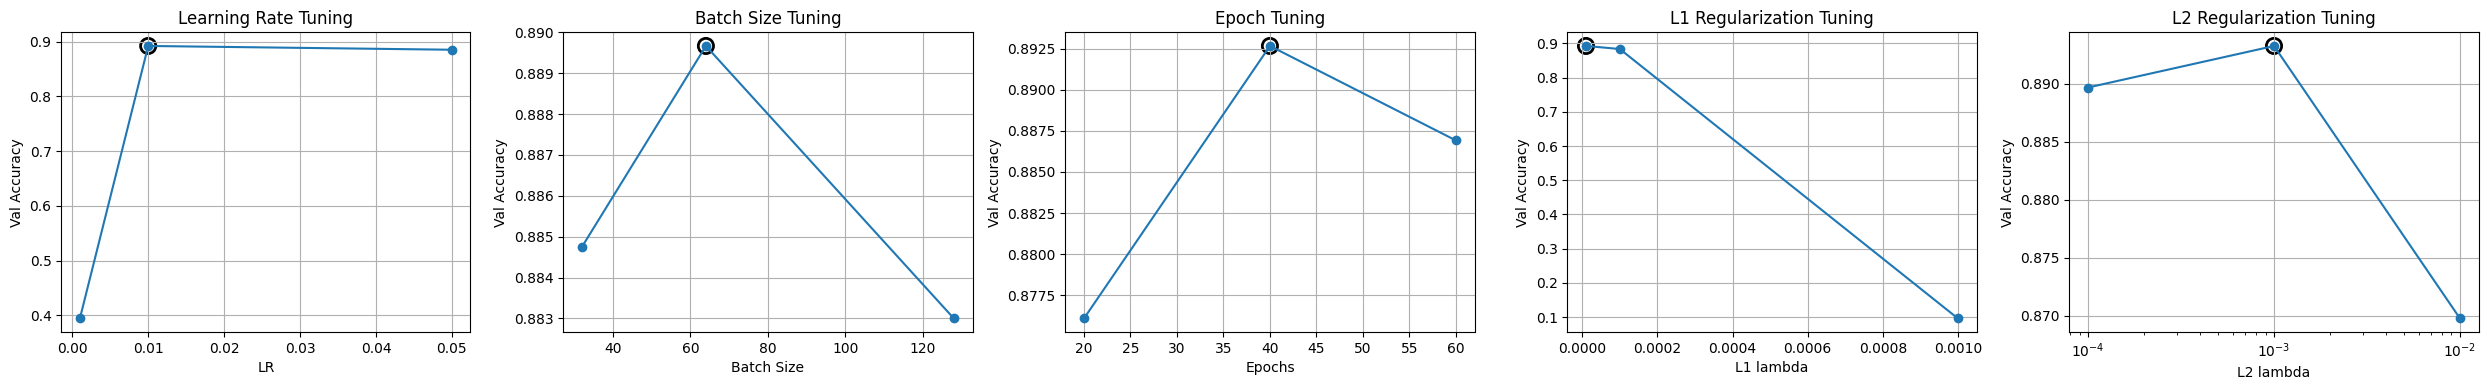

In [46]:
lrs = sorted(lr_tuning_results.keys())
lr_accs = [lr_tuning_results[lr] for lr in lrs]

bss = sorted(bs_tuning_results.keys())
bs_accs = [bs_tuning_results[bs] for bs in bss]

eps = sorted(epoch_tuning_results.keys())
ep_accs = [epoch_tuning_results[ep] for ep in eps]

l1s = sorted(l1_tuning_results.keys())
l1_accs = [l1_tuning_results[l1] for l1 in l1s]

l2s = sorted(l2_tuning_results.keys())
l2_accs = [l2_tuning_results[l2] for l2 in l2s]

fig, axes = plt.subplots(1, 5, figsize=(25, 4))

# 1. Learning Rate
ax = axes[0]
ax.plot(lrs, lr_accs, marker="o")
ax.set_title("Learning Rate Tuning")
ax.set_xlabel("LR")
ax.set_ylabel("Val Accuracy")
ax.grid(True)
ax.scatter(
    [best_lr],
    [lr_tuning_results[best_lr]],
    s=120,
    edgecolor="black",
    facecolor="none",
    linewidth=2
)

# 2. Batch Size
ax = axes[1]
ax.plot(bss, bs_accs, marker="o")
ax.set_title("Batch Size Tuning")
ax.set_xlabel("Batch Size")
ax.set_ylabel("Val Accuracy")
ax.grid(True)
ax.scatter(
    [best_bs],
    [bs_tuning_results[best_bs]],
    s=120,
    edgecolor="black",
    facecolor="none",
    linewidth=2
)

# 3. Epochs
ax = axes[2]
ax.plot(eps, ep_accs, marker="o")
ax.set_title("Epoch Tuning")
ax.set_xlabel("Epochs")
ax.set_ylabel("Val Accuracy")
ax.grid(True)
ax.scatter(
    [best_epochs],
    [epoch_tuning_results[best_epochs]],
    s=120,
    edgecolor="black",
    facecolor="none",
    linewidth=2
)

# 4. L1 Regularization
ax = axes[3]
ax.plot(l1s, l1_accs, marker="o")
ax.set_title("L1 Regularization Tuning")
ax.set_xlabel("L1 lambda")
ax.set_ylabel("Val Accuracy")
ax.grid(True)
ax.scatter(
    [best_l1],
    [l1_tuning_results[best_l1]],
    s=120,
    edgecolor="black",
    facecolor="none",
    linewidth=2
)

# 5. L2 Regularization
ax = axes[4]
ax.plot(l2s, l2_accs, marker="o")
ax.set_title("L2 Regularization Tuning")
ax.set_xlabel("L2 lambda")
ax.set_ylabel("Val Accuracy")
ax.grid(True)
ax.set_xscale("log")
ax.scatter(
    [best_l2],
    [l2_tuning_results[best_l2]],
    s=120,
    edgecolor="black",
    facecolor="none",
    linewidth=2
)

plt.tight_layout()
plt.show()

Now we will use the best hyperparameters we've found to run the experiments

In [47]:
results_store = {}

In [48]:
def run_experiment(name, X_train, y_train, X_val, y_val, hidden_layers=None, config=None):
  if hidden_layers is None:
    hidden_layers = []

  if config is None:
    config = {}

  params = {
      "output_dim": 10,
      "activation": "relu",
      "l1_lambda": 0.0,
      "l2_lambda": 0.0,
      "epochs": best_epochs,
      "lr": best_lr,
      "batch_size": best_bs,
      "verbose": False
  }

  params.update(config)

  # fit
  input_dim = X_train.shape[1]
  mlp = MLP(input_dim=input_dim, hidden_layers=hidden_layers, output_dim=params["output_dim"],
            activation=params["activation"], l1_lambda=params["l1_lambda"], l2_lambda=params["l2_lambda"])

  # measure training time
  start_time = time.time()

  loss_history = mlp.fit(X_train, y_train, epochs=params["epochs"], lr=params["lr"], batch_size=params["batch_size"], verbose=params["verbose"])

  end_time = time.time()
  training_time = end_time - start_time

  # evaluate
  y_pred = mlp.predict(X_val)
  acc = evaluate_acc(y_val, y_pred)

  # store results
  results_store[name] = {
      "loss_history": loss_history,
      "acc": acc,
      "training_time": training_time
  }

  if params["verbose"]:
    print(f"Experiment '{name}', acc: {acc:.4f}")

  # return mlp # in case we need the fitted model later

In [49]:
# 1: Depth
run_experiment("Q1: 0-Hidden", X_train_np, y_train_np, X_test_np, y_test_np, hidden_layers=[])
run_experiment("Q2: 1-Hidden", X_train_np, y_train_np, X_test_np, y_test_np, hidden_layers=[256])
run_experiment("Q3: 2-Hidden", X_train_np, y_train_np, X_test_np, y_test_np, hidden_layers=[256, 256], config={"activation": "relu"})

In [50]:
# 2: Activations
run_experiment("Q4: tanh", X_train_np, y_train_np, X_test_np, y_test_np, hidden_layers=[256, 256], config={"activation": "tanh"})
run_experiment("Q5: Leaky Re-LU", X_train_np, y_train_np, X_test_np, y_test_np, hidden_layers=[256, 256], config={"activation": "leaky_relu"})

In [51]:
# 3: Regularization
run_experiment("Q6: L1", X_train_np, y_train_np, X_test_np, y_test_np, hidden_layers=[256, 256], config={"l1_lambda": best_l1})
run_experiment("Q7: L2", X_train_np, y_train_np, X_test_np, y_test_np, hidden_layers=[256, 256], config={"l2_lambda": best_l2})
run_experiment("Q8: L1 and L2", X_train_np, y_train_np, X_test_np, y_test_np, hidden_layers=[256, 256], config={"l1_lambda": best_l1, "l2_lambda": best_l2})

In [52]:
# 4: Unnormalized Images
run_experiment("Q9: Unnormalized", X_train_unnormalized, y_train_np, X_test_unnormalized, y_test_np, hidden_layers=[256, 256])

In [53]:
run_experiment(
    "Q10: SimpleScaled",
    X_train_simple,
    y_train_np,
    X_test_simple,
    y_test_np,
    hidden_layers=[256, 256]
)

In [54]:
static_train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

aug_ds_full = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=static_train_transform
)

aug_train_ds = torch.utils.data.Subset(aug_ds_full, train_idx) # same train/val split from before

aug_loader = DataLoader(aug_train_ds, batch_size=len(aug_train_ds), shuffle=False)
X_aug_batch, y_aug_batch = next(iter(aug_loader))

In [55]:
# flatten
X_aug_flat = X_aug_batch.view(X_aug_batch.size(0), -1) # (N, 1, 28, 28) -> (N, 784)

# zero center
X_aug_zc = X_aug_flat - mean_vector

# Decorrelate (Rotate) using original U
X_aug_rot = X_aug_zc @ U

# Whiten using original eigenvalues
X_aug_white = X_aug_rot / torch.sqrt(eigvals + epsilon)

# Convert to Numpy for the MLP
X_train_aug_np = to_numpy(X_aug_white).astype(np.float32)
y_train_aug_np = to_numpy(y_aug_batch).astype(np.int64)

X_train_combined = np.concatenate((X_train_np, X_train_aug_np), axis=0)
y_train_combined = np.concatenate((y_train_np, y_train_aug_np), axis=0)

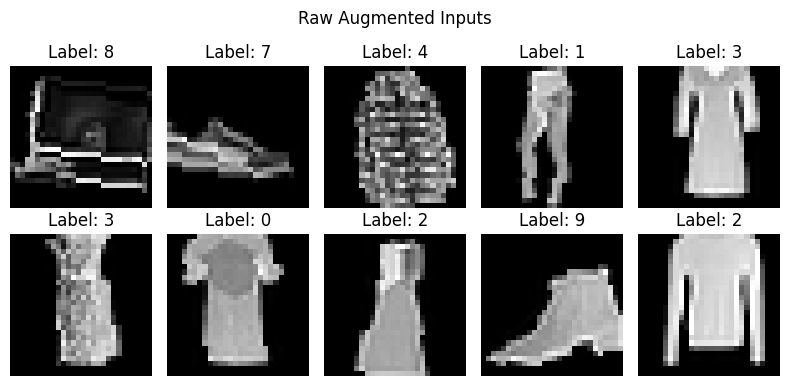

In [56]:
# visualizing augmented data
aug_samples_raw = X_aug_batch[:10].view(-1, 28, 28)
aug_labels_raw = y_aug_batch[:10]

show_grid(to_numpy(aug_samples_raw), to_numpy(aug_labels_raw), "Raw Augmented Inputs")

In [57]:
aug_config = {
    "epochs": 60, # may need more epochs for augmented data as it is 'harder' to learn
}

run_experiment(
    "Q11: Augmented",
    X_train_aug_np,
    y_train_aug_np,
    X_val_np,
    y_val_np,
    hidden_layers=[256, 256],
    config=aug_config
)

In [58]:
comb_config = {
    "epochs": 60,
}

run_experiment(
    "Q12: Combined",
    X_train_combined,
    y_train_combined,
    X_val_np,
    y_val_np,
    hidden_layers=[256, 256],
    config=comb_config
)

In [59]:
exp_order = [
    "Q1: 0-Hidden",
    "Q2: 1-Hidden",
    "Q3: 2-Hidden",
    "Q4: tanh",
    "Q5: Leaky Re-LU",
    "Q6: L1",
    "Q7: L2",
    "Q8: L1 and L2",
    "Q9: Unnormalized",
    "Q10: SimpleScaled",
    "Q11: Augmented",
    "Q12: Combined"
]

In [60]:
for name in exp_order:
  print(f"{name}: {results_store[name]['acc']:.4f}")

Q1: 0-Hidden: 0.8392
Q2: 1-Hidden: 0.8788
Q3: 2-Hidden: 0.8813
Q4: tanh: 0.8550
Q5: Leaky Re-LU: 0.8834
Q6: L1: 0.8831
Q7: L2: 0.8853
Q8: L1 and L2: 0.8817
Q9: Unnormalized: 0.8828
Q10: SimpleScaled: 0.8598
Q11: Augmented: 0.8023
Q12: Combined: 0.8732


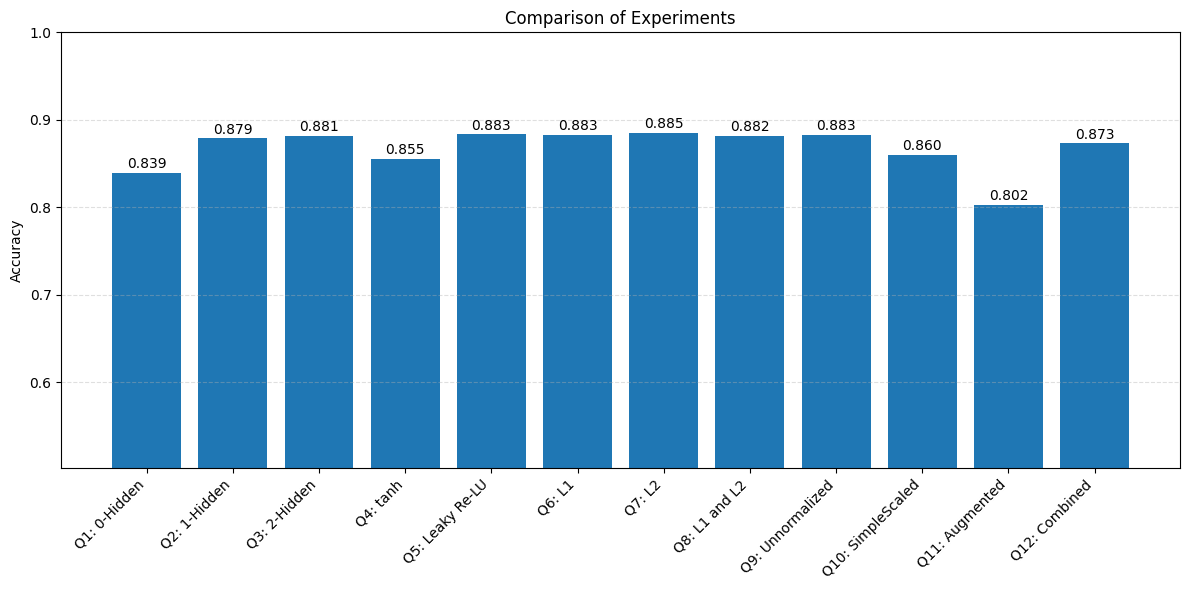

In [61]:
accuracies = [results_store[name]["acc"] for name in exp_order]

plt.figure(figsize=(12, 6))
bars = plt.bar(exp_order, accuracies)

for bar, acc in zip(bars, accuracies):
    y = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        y + 0.002,
        f"{acc:.3f}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Comparison of Experiments")
plt.ylim(min(accuracies) - 0.3, min(max(accuracies) + 0.3, 1))
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

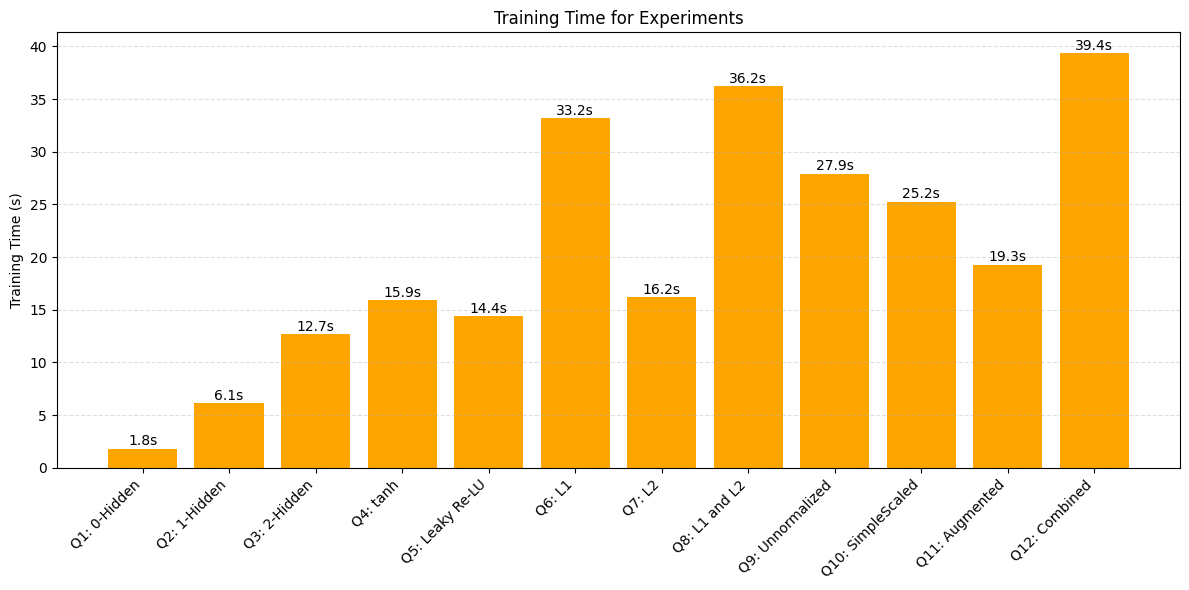

In [62]:
times = [results_store[name]["training_time"] for name in exp_order]

plt.figure(figsize=(12, 6))
bars = plt.bar(exp_order, times, color='orange')

for bar, t in zip(bars, times):
    y = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        y + 0.05,
        f"{t:.1f}s",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.xticks(rotation=45, ha='right')
plt.ylabel("Training Time (s)")
plt.title("Training Time for Experiments")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## CNN

In [63]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
print(f"Using device: {device}")
# would be faster if cuda is available

Using device: mps


In [64]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # layer 1: Conv -> ReLU -> MaxPool
        # input: (1, 28, 28)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # layer 2: Conv -> ReLU -> MaxPool
        # input: (32, 14, 14)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Output after pool: (64, 7, 7)

        # fully connected layers
        # flatten size: 64 channels * 7 * 7 pixels = 3136
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10) # Output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # convolutional block 1
        x = self.pool(F.relu(self.conv2(x))) # convolutional block 2

        x = x.view(-1, 64 * 7 * 7) # flatten

        x = F.relu(self.fc1(x)) # hidden Layer

        x = self.fc2(x) # output layer
        return x

In [65]:
def train_cnn(model, train_loader, val_loader, epochs=10, verbose=False):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.to(device)

    start_time = time.time()

    loss_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)

        if verbose:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

    total_time = time.time() - start_time

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    return acc, total_time,loss_history

In [66]:
transform_normal = transforms.Compose([
    transforms.ToTensor(),
])

# augmented transform
transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

In [67]:
# using original split indices (train_idx, val_idx)
full_train_data_normal = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_normal)
full_train_data_aug = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_aug)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_normal)

train_subset_normal = torch.utils.data.Subset(full_train_data_normal, train_idx)
train_subset_aug = torch.utils.data.Subset(full_train_data_aug, train_idx)
val_subset = torch.utils.data.Subset(full_train_data_normal, val_idx) # val set is never augmented

train_subset_combined = ConcatDataset([train_subset_normal, train_subset_aug])

# data Loaders
batch_size = 64
loader_normal = DataLoader(train_subset_normal, batch_size=batch_size, shuffle=True)
loader_aug = DataLoader(train_subset_aug, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
loader_combined = DataLoader(train_subset_combined, batch_size=64, shuffle=True)

In [68]:
# standard CNN
cnn_normal = SimpleCNN()
acc_normal, time_normal, lh_normal = train_cnn(cnn_normal, loader_normal, loader_val, epochs=15)

In [69]:
# augmented CNN
cnn_aug = SimpleCNN()
acc_aug, time_augmented, lh_aug = train_cnn(cnn_aug, loader_aug, loader_val, epochs=15)

In [70]:
# combined CNN
cnn_combined = SimpleCNN()
acc_combined, time_combined, lg_combined = train_cnn(cnn_combined, loader_combined, loader_val, epochs=15)

In [71]:
print(f"Standard CNN Accuracy: {acc_normal:.4f}")
print(f"Augmented CNN Accuracy: {acc_aug:.4f}")
print(f"Combined CNN Accuracy: {acc_combined:.4f}")

Standard CNN Accuracy: 0.9168
Augmented CNN Accuracy: 0.9233
Combined CNN Accuracy: 0.9327


In [72]:
best_mlp = max(results_store, key=lambda name: results_store[name]["acc"])
print("Best MLP:", best_mlp, results_store[best_mlp]["acc"])

Best MLP: Q7: L2 0.8853


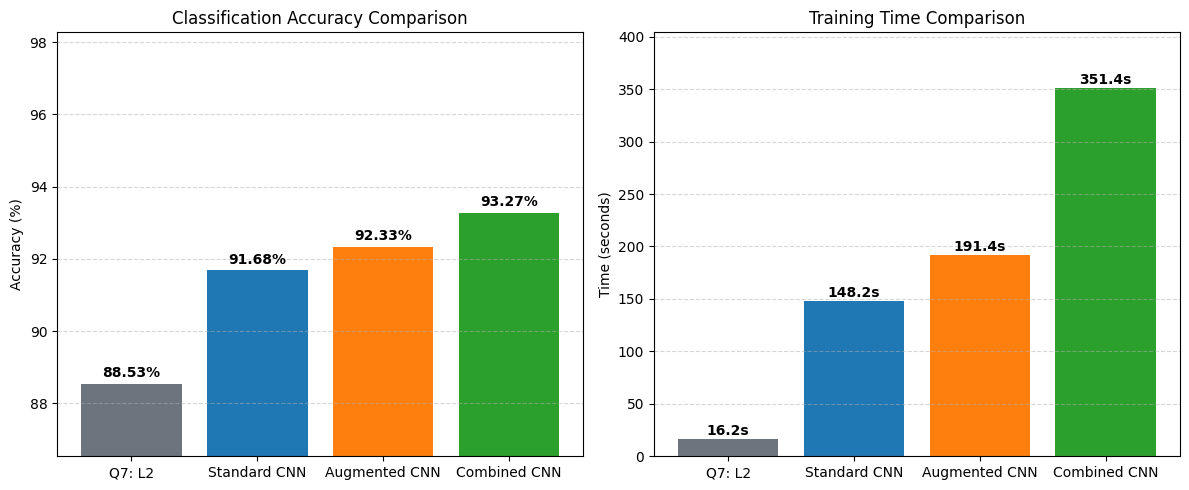

In [73]:
results_comparison = {
    best_mlp: {
        "acc": results_store[best_mlp]["acc"],
        "time": results_store[best_mlp]["training_time"]
    },
    "Standard CNN": {
        "acc": acc_normal,
        "time": time_normal
    },
    "Augmented CNN": {
        "acc": acc_aug,
        "time": time_augmented
    },
    "Combined CNN": {
        "acc": acc_combined,
        "time": time_combined
    }
}

models_names = list(results_comparison.keys())

accuracies = [results_comparison[m]["acc"] * 100 for m in models_names]
times = [results_comparison[m]["time"] for m in models_names]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

colors = ['#6c757d', '#1f77b4', '#ff7f0e', '#2ca02c']  # grey, blue, orange, green

bars1 = ax1.bar(models_names, accuracies, color=colors)
ax1.set_title("Classification Accuracy Comparison", fontsize=12)
ax1.set_ylabel("Accuracy (%)")
ax1.set_ylim(min(accuracies) - 2, max(accuracies) + 5)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')

bars2 = ax2.bar(models_names, times, color=colors)
ax2.set_title("Training Time Comparison", fontsize=12)
ax2.set_ylabel("Time (seconds)")
ax2.set_ylim(0, max(times) * 1.15)
ax2.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## ResNet

In [74]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

In [75]:
train_transform_resnet = transforms.Compose([
    transforms.Resize(224), # 224x224 to match ResNet's expected input resolution
    transforms.Grayscale(num_output_channels=3), # ResNet needs 3 channels
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    # apparently the weights expect the ImageNet distribution
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# validation transform (resize/mormalize but no augmentation)
val_transform_resnet = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

In [76]:
tl_train_full = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=train_transform_resnet
)

tl_val_full = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=val_transform_resnet
)

# same indices as before
tl_train_ds = torch.utils.data.Subset(tl_train_full, train_idx)
tl_val_ds = torch.utils.data.Subset(tl_val_full, val_idx)

batch_size_tl = 64

tl_train_loader = DataLoader(tl_train_ds, batch_size=batch_size_tl, shuffle=True)
tl_val_loader   = DataLoader(tl_val_ds,   batch_size=batch_size_tl, shuffle=False)

In [77]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False
in_features = model.fc.in_features

0.8%

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/gabriel/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100.0%


In [78]:
model.fc = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)
)

model = model.to(device)

In [79]:
# we call it transfer model because the procedure of using a model
# trained on a large dataset (ImageNet in this case) and trying to
# train a small new component on top is called "Transfer Learning"

def train_transfer_model(
    model,
    train_loader,
    val_loader,
    device,
    epochs=10,
    lr=1e-3,
    weight_decay=0.0,
    verbose=True
):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        [p for p in model.parameters() if p.requires_grad],
        lr=lr,
        weight_decay=weight_decay
    )

    best_val_acc = 0.0
    best_state_dict = None

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            running_total += labels.size(0)

        train_loss = running_loss / running_total
        train_acc  = running_correct / running_total

        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        if verbose:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} | "
                  f"Train Acc: {train_acc:.4f} | "
                  f"Val Acc: {val_acc:.4f}")

    total_time = time.time() - start_time

    # restore best weights
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    return best_val_acc, total_time

In [80]:
tl_val_acc, tl_time = train_transfer_model(
    model,
    tl_train_loader,
    tl_val_loader,
    device,
    epochs=10,
    lr=1e-3,
    weight_decay=1e-4,
    verbose=True
)

Epoch 1/10 | Train Loss: 0.7466 | Train Acc: 0.7341 | Val Acc: 0.8119
Epoch 2/10 | Train Loss: 0.5836 | Train Acc: 0.7899 | Val Acc: 0.8276
Epoch 3/10 | Train Loss: 0.5536 | Train Acc: 0.7992 | Val Acc: 0.8233
Epoch 4/10 | Train Loss: 0.5297 | Train Acc: 0.8066 | Val Acc: 0.8213
Epoch 5/10 | Train Loss: 0.5198 | Train Acc: 0.8100 | Val Acc: 0.8391
Epoch 6/10 | Train Loss: 0.5112 | Train Acc: 0.8136 | Val Acc: 0.8363
Epoch 7/10 | Train Loss: 0.5025 | Train Acc: 0.8173 | Val Acc: 0.8339
Epoch 8/10 | Train Loss: 0.4939 | Train Acc: 0.8190 | Val Acc: 0.8478
Epoch 9/10 | Train Loss: 0.4897 | Train Acc: 0.8203 | Val Acc: 0.8458
Epoch 10/10 | Train Loss: 0.4861 | Train Acc: 0.8223 | Val Acc: 0.8456


In [81]:
print(f"Transfer model (2 FC layers: acc = {tl_val_acc:.4f}, time = {tl_time:.2f}s")

Transfer model (2 FC layers: acc = 0.8478, time = 1530.00s


/var/folders/h1/gp6tlks16mn1f17d76t4fjk80000gn/T/ipykernel_95456/405662301.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(models_names, rotation=30, ha='right')
/var/folders/h1/gp6tlks16mn1f17d76t4fjk80000gn/T/ipykernel_95456/405662301.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(models_names, rotation=30, ha='right')


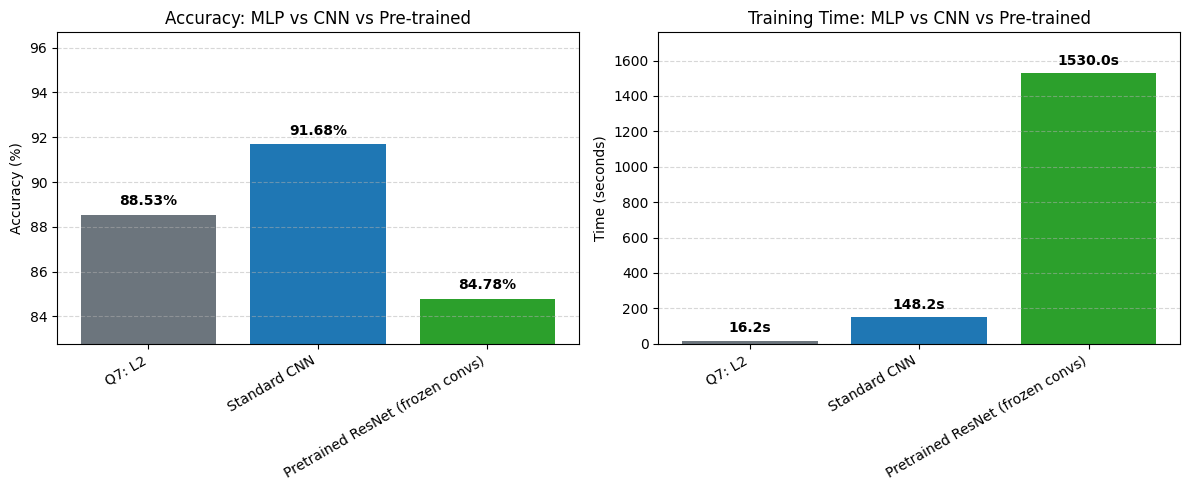

In [82]:
# comparison: best MLP, regular CNN, pre-trained model
results_transfer = {
    best_mlp: {
        "acc": results_store[best_mlp]["acc"],
        "time": results_store[best_mlp]["training_time"]
    },
    "Standard CNN": {
        "acc": acc_normal,
        "time": time_normal
    },
    "Pretrained ResNet (frozen convs)": {
        "acc": tl_val_acc,
        "time": tl_time
    }
}

models_names = list(results_transfer.keys())
accuracies = [results_transfer[m]["acc"] * 100 for m in models_names]  # to %
times = [results_transfer[m]["time"] for m in models_names]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

colors = ['#6c757d', '#1f77b4', '#2ca02c']  # grey, blue, green
bars1 = ax1.bar(models_names, accuracies, color=colors)
ax1.set_title("Accuracy: MLP vs CNN vs Pre-trained", fontsize=12)
ax1.set_ylabel("Accuracy (%)")
ax1.set_ylim(min(accuracies) - 2, max(accuracies) + 5)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars1:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.,
        height + 0.3,
        f'{height:.2f}%',
        ha='center',
        va='bottom',
        fontweight='bold'
    )

ax1.set_xticklabels(models_names, rotation=30, ha='right')

bars2 = ax2.bar(models_names, times, color=colors)
ax2.set_title("Training Time: MLP vs CNN vs Pre-trained", fontsize=12)
ax2.set_ylabel("Time (seconds)")
ax2.set_ylim(0, max(times) * 1.15)
ax2.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars2:
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.,
        height + max(times) * 0.02,
        f'{height:.1f}s',
        ha='center',
        va='bottom',
        fontweight='bold'
    )

ax2.set_xticklabels(models_names, rotation=30, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
modelA = models.resnet18(pretrained=True)
for p in modelA.parameters():
    p.requires_grad = False

in_features = modelA.fc.in_features
modelA.fc = nn.Linear(in_features, 10)
modelA = modelA.to(device)

accA, timeA = train_transfer_model(modelA, tl_train_loader, tl_val_loader, device, epochs=10, lr=1e-3)

/Users/gabriel/Projects/comp551/miniproject3/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gabriel/Projects/comp551/miniproject3/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 | Train Loss: 0.7346 | Train Acc: 0.7592 | Val Acc: 0.8073
Epoch 2/10 | Train Loss: 0.5296 | Train Acc: 0.8123 | Val Acc: 0.8200
Epoch 3/10 | Train Loss: 0.5021 | Train Acc: 0.8216 | Val Acc: 0.8256
Epoch 4/10 | Train Loss: 0.4801 | Train Acc: 0.8264 | Val Acc: 0.8293
Epoch 5/10 | Train Loss: 0.4682 | Train Acc: 0.8347 | Val Acc: 0.8419


In [ ]:
modelB = models.resnet18(pretrained=True)
for p in modelB.parameters():
    p.requires_grad = False

in_features = modelB.fc.in_features
modelB.fc = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)
)
modelB = modelB.to(device)

accB, timeB = train_transfer_model(modelB, tl_train_loader, tl_val_loader, device, epochs=10, lr=1e-3)

Epoch 1/10 | Train Loss: 0.7562 | Train Acc: 0.7320 | Val Acc: 0.8057
Epoch 2/10 | Train Loss: 0.5834 | Train Acc: 0.7892 | Val Acc: 0.8177
Epoch 3/10 | Train Loss: 0.5470 | Train Acc: 0.8017 | Val Acc: 0.8196
Epoch 4/10 | Train Loss: 0.5284 | Train Acc: 0.8069 | Val Acc: 0.8359
Epoch 5/10 | Train Loss: 0.5195 | Train Acc: 0.8114 | Val Acc: 0.8360
Epoch 6/10 | Train Loss: 0.5053 | Train Acc: 0.8171 | Val Acc: 0.8367
Epoch 7/10 | Train Loss: 0.4997 | Train Acc: 0.8155 | Val Acc: 0.8322
Epoch 8/10 | Train Loss: 0.4907 | Train Acc: 0.8204 | Val Acc: 0.8498
Epoch 9/10 | Train Loss: 0.4882 | Train Acc: 0.8202 | Val Acc: 0.8455
Epoch 10/10 | Train Loss: 0.4806 | Train Acc: 0.8216 | Val Acc: 0.8430


In [ ]:
modelC = models.resnet18(pretrained=True)
for p in modelC.parameters():
    p.requires_grad = False

in_features = modelC.fc.in_features
modelC.fc = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)
)
modelC = modelC.to(device)

accC, timeC = train_transfer_model(modelC, tl_train_loader, tl_val_loader, device, epochs=10, lr=1e-3)

Epoch 1/10 | Train Loss: 0.7944 | Train Acc: 0.7071 | Val Acc: 0.8003
Epoch 2/10 | Train Loss: 0.6100 | Train Acc: 0.7809 | Val Acc: 0.8275
Epoch 3/10 | Train Loss: 0.5791 | Train Acc: 0.7904 | Val Acc: 0.8251
Epoch 4/10 | Train Loss: 0.5624 | Train Acc: 0.7969 | Val Acc: 0.8392
Epoch 5/10 | Train Loss: 0.5433 | Train Acc: 0.8042 | Val Acc: 0.8357
Epoch 6/10 | Train Loss: 0.5348 | Train Acc: 0.8083 | Val Acc: 0.8389
Epoch 7/10 | Train Loss: 0.5280 | Train Acc: 0.8102 | Val Acc: 0.8355
Epoch 8/10 | Train Loss: 0.5219 | Train Acc: 0.8137 | Val Acc: 0.8401
Epoch 9/10 | Train Loss: 0.5132 | Train Acc: 0.8160 | Val Acc: 0.8408
Epoch 10/10 | Train Loss: 0.5064 | Train Acc: 0.8163 | Val Acc: 0.8476


In [ ]:
print("A (0 hidden): acc =", accA, ", time =", timeA)
print("B (1 hidden): acc =", accB, ", time =", timeB)
print("C (2 hidden): acc =", accC, ", time =", timeC)

A (0 hidden): acc = 0.843 , time = 1005.7917885780334
B (1 hidden): acc = 0.8498333333333333 , time = 979.0062880516052
C (2 hidden): acc = 0.8475833333333334 , time = 1004.813681602478


In [ ]:
head_results = {
    "A: 0 hidden (Linear)": {
        "acc": accA,
        "time": timeA,
    },
    "B: 1 hidden (256)": {
        "acc": accB,
        "time": timeB,
    },
    "C: 2 hidden (512→256)": {
        "acc": accC,
        "time": timeC,
    }
}

/tmp/ipython-input-4023128915.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(models_names, rotation=20, ha='right')
/tmp/ipython-input-4023128915.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(models_names, rotation=20, ha='right')


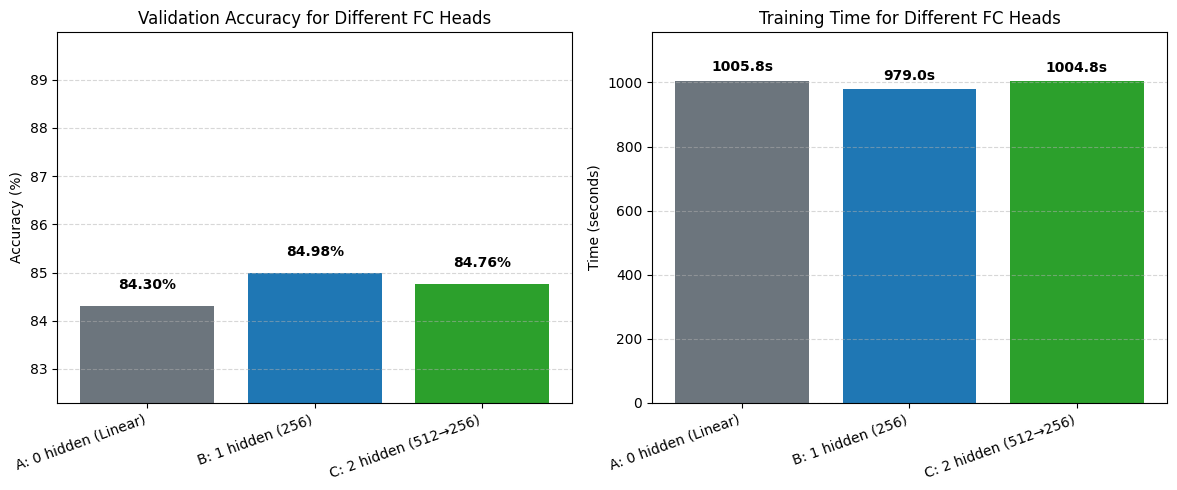

In [ ]:
models_names = list(head_results.keys())
accuracies = [head_results[m]["acc"] * 100 for m in models_names]
times = [head_results[m]["time"] for m in models_names]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

colors = ['#6c757d', '#1f77b4', '#2ca02c']  # grey, blue, green
bars1 = ax1.bar(models_names, accuracies, color=colors)
ax1.set_title("Validation Accuracy for Different FC Heads", fontsize=12)
ax1.set_ylabel("Accuracy (%)")
ax1.set_ylim(min(accuracies) - 2, max(accuracies) + 5)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars1:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.,
        height + 0.3,
        f'{height:.2f}%',
        ha='center',
        va='bottom',
        fontweight='bold'
    )

ax1.set_xticklabels(models_names, rotation=20, ha='right')

bars2 = ax2.bar(models_names, times, color=colors)
ax2.set_title("Training Time for Different FC Heads", fontsize=12)
ax2.set_ylabel("Time (seconds)")
ax2.set_ylim(0, max(times) * 1.15)
ax2.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars2:
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.,
        height + max(times) * 0.02,
        f'{height:.1f}s',
        ha='center',
        va='bottom',
        fontweight='bold'
    )

ax2.set_xticklabels(models_names, rotation=20, ha='right')

plt.tight_layout()
plt.show()